## POS Tagging
Parts of speech tagging

In [1]:
import nltk

In [16]:
nltk.download()

showing info http://www.nltk.org/nltk_data/


True

In [2]:
nltk.pos_tag("Machine Learning is great".split())

[('Machine', 'NN'), ('Learning', 'NNP'), ('is', 'VBZ'), ('great', 'JJ')]

In [3]:
# So, Machine is 'NN' means Noun
# Learning is 'NN' means Noun
# is is 'VBZ' means verb
# great is 'JJ' means adjective

To get the detailed information of these acronyms please refer-
http://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

## Stemming and Lemmatization
Both reduce words to the "base" form. Used in bag of words approach.

In [4]:
from nltk.stem.porter import PorterStemmer

In [5]:
porter_stemmer = PorterStemmer()

In [6]:
porter_stemmer.stem('wolves') # input is a token (word)

'wolv'

In [7]:
# Here we can see that 'wolves' is stemmed to 'wolv' which is not a word. So, it just chops the letter and brings it to the base
# form. This is a very crude way to doing. But, lemmatizer is more elegant

In [8]:
from nltk.stem import WordNetLemmatizer

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
lemmatizer.lemmatize('wolves')

'wolf'

In [11]:
# You can see that it lemmatizes wolves to 'wolf' which is a real world.

## NER (Named Entity Recognition)

In [12]:
s = 'Albert Einstein was born on March 14, 1879'

In [18]:
tags = nltk.pos_tag(s.split())
tags

[('Albert', 'NNP'),
 ('Einstein', 'NNP'),
 ('was', 'VBD'),
 ('born', 'VBN'),
 ('on', 'IN'),
 ('March', 'NNP'),
 ('14,', 'CD'),
 ('1879', 'CD')]

In [15]:
# So, these tags (POS Tags) are the input to the NER

In [20]:
entities = nltk.ne_chunk(tags)

In [22]:
entities.__repr__()

"Tree('S', [Tree('PERSON', [('Albert', 'NNP')]), Tree('PERSON', [('Einstein', 'NNP')]), ('was', 'VBD'), ('born', 'VBN'), ('on', 'IN'), ('March', 'NNP'), ('14,', 'CD'), ('1879', 'CD')])"

In [23]:
# You can see that Albert Einstein is tagged as a person.

Note: You might error if you are trying to just print the entities and not with __repr__.


Follow this instruction: http://stackoverflow.com/questions/39007755/cant-find-ghostscript-in-nltk

In [25]:
entities.draw()  # gives a pictorial representation of the NER

In [26]:
s = "Steve Jobbs was the CEO of Apple Corp."

In [27]:
tags = nltk.pos_tag(s.split())
tags

[('Steve', 'NNP'),
 ('Jobbs', 'NNP'),
 ('was', 'VBD'),
 ('the', 'DT'),
 ('CEO', 'NNP'),
 ('of', 'IN'),
 ('Apple', 'NNP'),
 ('Corp.', 'NNP')]

In [28]:
entities = nltk.ne_chunk(tags)
entities.__repr__()

"Tree('S', [Tree('PERSON', [('Steve', 'NNP')]), Tree('PERSON', [('Jobbs', 'NNP')]), ('was', 'VBD'), ('the', 'DT'), Tree('ORGANIZATION', [('CEO', 'NNP')]), ('of', 'IN'), Tree('ORGANIZATION', [('Apple', 'NNP')]), ('Corp.', 'NNP')])"

In [29]:
entities.draw()

## Latent Semantic Analysis
What if you have multiple words with the same meaning (synonyms) e.g. "Buy" and "Purchase" ; "Big" and "Large"; "Quick" and "Speedy" etc.
    
Or one word with multiple meanings (polysemes) e.g. "Man", "Milk" etc.

You can solve this problem by combining words with similar meanings. e.g. z = 0.7*computer + 0.5*PC + 0.6*laptop. It means they are highly correlated. You can think them as Latent Variables or hidden vaiable that represents all of them

The task of LSA is to find these variables and transform the original data, into these new variables and the dimensionality of this data would be much smaller that original. So, LSA clearly solves the Synonomy problem by correlating the variables.

But we are still not sure if it helps solve the problem of Polysemy

#### Mathematics behind LSA

LSA is really just "SVD" or Singular Value Decomposition to a term-document matrix. PCA is a simplier form of SVD
Read the maths from the Udemy course (https://www.udemy.com/data-science-natural-language-processing-in-python/learn/v4/t/lecture/4507812?start=0) or elsewhere

Also, read this for more detail-

https://lazyprogrammer.me/tutorial-principal-components-analysis-pca/

In [30]:
# The data is a bunch of book titles one on each line

In [95]:
import nltk
import numpy as np
import matplotlib.pyplot as plt

In [33]:
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD

In [34]:
wordnet_lemmatizer = WordNetLemmatizer()

In [35]:
titles = [line.rstrip() for line in open('all_book_titles.txt')]

In [37]:
len(titles) # 2373 book titles

2373

In [38]:
titles[0:3]

['Philosophy of Sex and Love A Reader',
 'Readings in Judaism, Christianity, and Islam',
 'Microprocessors Principles and Applications']

In [43]:
stopwords = set(w.rstrip() for w in open('stopwords.txt'))

In [45]:
# Add our own stopwords
stopwords = stopwords.union({
        'introduction', 'edition', 'series', 'application',
        'approach', 'card', 'access', 'package', 'plus', 'etext',
        'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
        'third', 'second', 'fourth'})

In [78]:
def my_tokenizer(s):
    s = s.lower()
    tokens = nltk.tokenize.word_tokenize(s)  # tokenize the words (splits the word based on space as a delimiter)
    tokens = [t for t in tokens if len(t) > 2] # only take words more than 2 letters
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens]  # lemmatize them
    tokens = [t for t in tokens if t not in stopwords] # removing the stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)]  # remove the numbers like 1stm 2nd editions etc.
    return tokens

In [79]:
# Now I want to create an index for each of my words, so that each word will have its own index in the final data vector.
word_index_map = {} # map words to indices
current_index = 0 # it will increase whenever I see a new word.
all_tokens = []
all_titles = []
index_word_map = []

for title in titles:
    # some of the titles have invalid ascii's. So, we will try to encode them in ASCII
    try:
        #title = title.encode('ascii', 'ignore')  # if it gives an exception we will just skip it.
        all_titles.append(title)
        tokens = my_tokenizer(title)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except:
        pass

In [85]:
# It's an unsupervised learning as there is no label

def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map)) # our vocabulary size
    for t in tokens:
        i = word_index_map[t] # get the index from the word_index_map
        x[i] = 1  # indicator variable which is 0 or 1 (binary)
    return x

In [86]:
N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N)) # as this is a term document matrices and not documents-term matrix
i = 0

for tokens in all_tokens:
    X[:, i] = tokens_to_vector(tokens)
    i += 1

In [87]:
X

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [88]:
svd = TruncatedSVD()

In [89]:
Z = svd.fit_transform(X)

In [90]:
Z

array([[ 0.08308068,  0.08982828],
       [ 0.13519671,  0.20382836],
       [ 0.0253216 ,  0.00816228],
       ..., 
       [ 0.01080238, -0.00071341],
       [ 0.01080238, -0.00071341],
       [ 0.01080238, -0.00071341]])

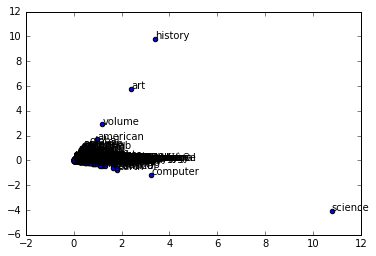

In [97]:
plt.scatter(Z[:, 0], Z[:, 1])
for i in range(D):
    plt.annotate(s = index_word_map[i], xy = (Z[i, 0], Z[i, 1]))
plt.show()